# Document for training and evaluation of resnet on texeldata

In [1]:
import albumentations as A
from fastai.vision.all import *

## Init setup

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET_PATH = Path("/home/mikkel/Documents/experts_in_teams_proj/vision/data/fence_data/texel_data/categories")

### Data as two categories

In [3]:
class ImageAlbumentationsTransform(Transform):
    """Class for applying the transformations on the images
    """
    def __init__(self, aug): 
        self.aug = aug
           
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),
    
])

tfm = ImageAlbumentationsTransform(trans)

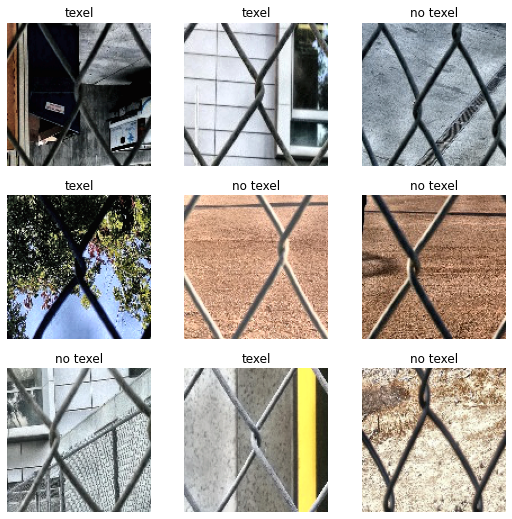

In [4]:
def label_func(fname):
    return 'texel' if 'true' in str(fname) else "no texel"

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=label_func,
    item_tfms=[ToTensor, tfm],
    splitter=RandomSplitter(valid_pct=0.2, seed=100),
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
)

dls = dblock.dataloaders(DATASET_PATH, bs=64, num_workers=8)


dls.show_batch()

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=3.311311274956097e-06)

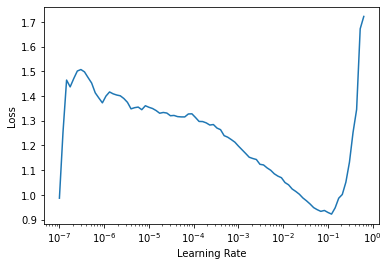

In [15]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, model_dir="/home/mikkel/Documents/experts_in_teams_proj/vision/texel_resnet50/models")
learn.lr_find()

In [12]:
learn.fit_one_cycle(50, 0.02, cbs=SaveModelCallback(monitor='valid_loss', comp=np.less))

epoch,train_loss,valid_loss,accuracy,time
0,0.130622,0.034322,0.986301,00:01
1,0.087113,0.140763,0.958904,00:01
2,0.063760,0.029257,0.972603,00:01
3,0.053231,0.042800,0.958904,00:01
4,0.043451,0.014686,0.986301,00:01
5,0.037988,0.023667,0.986301,00:01
6,0.032011,0.076043,0.972603,00:01
7,0.028396,0.005471,1.000000,00:01
8,0.042770,0.252873,0.904110,00:01
9,0.048653,0.243931,0.958904,00:01


Better model found at epoch 0 with valid_loss value: 0.034322433173656464.
Better model found at epoch 2 with valid_loss value: 0.02925739623606205.
Better model found at epoch 4 with valid_loss value: 0.01468611415475607.
Better model found at epoch 7 with valid_loss value: 0.005471070762723684.
Better model found at epoch 19 with valid_loss value: 0.0007959128124639392.
Better model found at epoch 26 with valid_loss value: 4.1967888364524697e-07.
Better model found at epoch 41 with valid_loss value: 1.9596043898673088e-08.


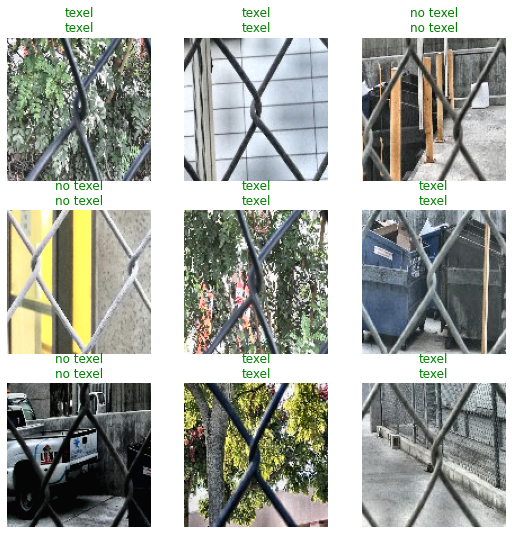

In [10]:
learn.show_results()

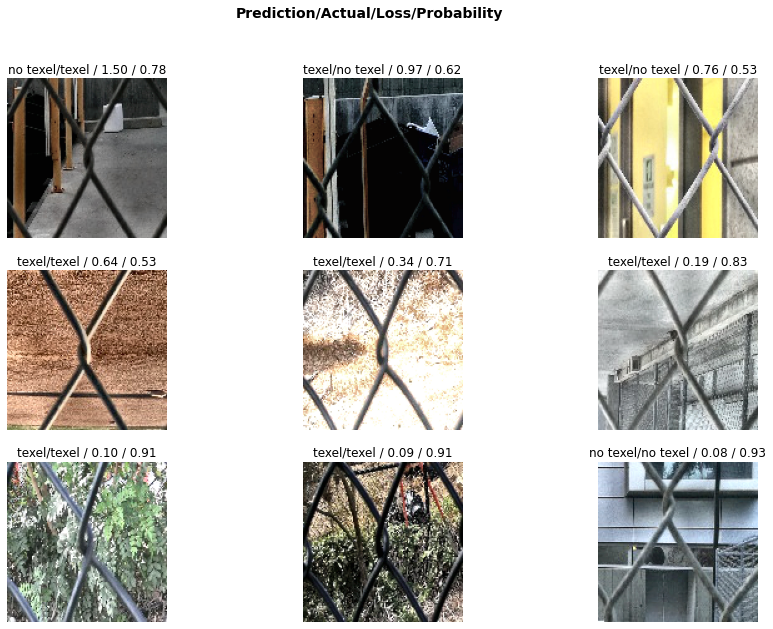

In [11]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))